In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from nltk.corpus import stopwords
import re
import string
import anyascii
from wordcloud import WordCloud

In [53]:
sns.set_theme()

In [54]:
input_df = pd.read_csv("./data/loader/outings.csv")
df = input_df.copy()

In [55]:
df.columns

Index(['document_id', 'quality', 'access_condition', 'avalanche_signs',
       'condition_rating', 'date_end', 'date_start', 'elevation_access',
       'elevation_down_snow', 'elevation_max', 'elevation_min',
       'elevation_up_snow', 'frequentation', 'glacier_rating',
       'height_diff_down', 'height_diff_up', 'hut_status', 'length_total',
       'lift_status', 'partial_trip', 'participant_count', 'public_transport',
       'hiking_rating', 'snow_quality', 'snow_quantity', 'global_rating',
       'height_diff_difficulties', 'engagement_rating', 'ski_rating',
       'labande_global_rating', 'activity_snow_ice_mixed', 'geom',
       'associated_route_ids', 'associated_forum_usernames', 'country',
       'admin_limits', 'range', 'cooked_lang', 'cooked_title',
       'cooked_description', 'cooked_summary', 'cooked_access_comment',
       'cooked_avalanches', 'cooked_conditions', 'cooked_conditions_levels',
       'cooked_hut_comment', 'cooked_participants', 'cooked_route_description',

In [56]:
df

,document_id,quality,access_condition,avalanche_signs,condition_rating,date_end,date_start,elevation_access,elevation_down_snow,elevation_max,...,link,activity_hiking,activity_skitouring,activity_mountain_climbing,activity_ice_climbing,activity_paragliding,activity_snowshoeing,activity_rock_climbing,activity_mountain_biking,activity_via_ferrata
0,978489,fine,NaN,['no'],good,2018-03-10,2018-03-10,NaN,NaN,2810.0,...,https://www.camptocamp.org/outings/978489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,641687,medium,cleared,NaN,good,2015-06-12,2015-06-12,1135.0,NaN,2339.0,...,https://www.camptocamp.org/outings/641687,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,879144,medium,NaN,['no'],good,2017-04-28,2017-04-28,NaN,1735.0,2831.0,...,https://www.camptocamp.org/outings/879144,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185409,medium,NaN,NaN,NaN,2008-04-14,2008-04-14,1970.0,NaN,2702.0,...,https://www.camptocamp.org/outings/185409,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1531141,fine,NaN,['no'],good,2023-05-01,2023-05-01,1730.0,2170.0,2529.0,...,https://www.camptocamp.org/outings/1531141,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6084,1603048,fine,NaN,['no'],average,2023-12-29,2023-12-29,1428.0,NaN,2712.0,...,https://www.camptocamp.org/outings/1603048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6085,1070679,great,NaN,NaN,good,2019-01-13,2019-01-13,1000.0,NaN,1989.0,...,https://www.camptocamp.org/outings/1070679,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6086,1472715,fine,NaN,NaN,excellent,2022-10-05,2022-10-05,1800.0,NaN,1941.0,...,https://www.camptocamp.org/outings/1472715,True,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
6087,797869,medium,NaN,NaN,NaN,2016-09-02,2016-09-02,1300.0,NaN,2939.0,...,https://www.camptocamp.org/outings/797869,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocess

## Ordered strings

In [57]:
def ordered_str_to_int(df, col, order):
    ordered_str_to_int = { order_str:i for order_str, i in zip(order, range(len(order))) }
    df[col] = df[col].astype(str).replace(ordered_str_to_int).astype(float)
    return df

In [58]:
# Global rating
# df["global_rating"].unique()
global_rating_order = [
    "F",
    "F+",
    "PD-",
    "PD",
    "PD+",
    "AD-",
    "AD",
    "AD+",
    "D-",
    "D",
    "D+",
    "TD-",
    "TD",
    "TD+",
    "ED-",
    "ED",
    "ED+"
]
df = ordered_str_to_int(df, "global_rating", global_rating_order)

In [59]:
# Frequentation
# df["frequentation"].unique()
frequentation_order = [
    "quiet",
    "some",
    "crowded",
    "overcrowded"
]
df = ordered_str_to_int(df, "frequentation", frequentation_order)

In [60]:
# glacier_rating
# df["glacier_rating"].unique()
glacier_rating_order = [
    "easy",
    "possible",
    "impossible"
]
df = ordered_str_to_int(df, "glacier_rating", glacier_rating_order)

In [61]:
# snow_quality
# df["snow_quality"].unique()
snow_quality_order = [
    "awful",
    "poor",
    "average",
    "good",
    "excellent"
]
df = ordered_str_to_int(df, "snow_quality", snow_quality_order)

In [62]:
# snow_quantity
# df["snow_quantity"].unique()
snow_quantity_order = [
    "awful",
    "poor",
    "average",
    "good",
    "excellent"
]
df = ordered_str_to_int(df, "snow_quantity", snow_quantity_order)

In [63]:
# engagement_rating
# df["engagement_rating"].unique()
engagement_rating_order = [
    "I",
    "II",
    "III",
    "IV",
    "V"
]
df = ordered_str_to_int(df, "engagement_rating", engagement_rating_order)

In [64]:
# hiking_rating
# df["hiking_rating"].unique()
hiking_rating_order = [
    "T1",
    "T2",
    "T3",
    "T4",
    "T5"
]
df = ordered_str_to_int(df, "hiking_rating", hiking_rating_order)

In [65]:
# ski_rating
# df["ski_rating"].unique()
ski_rating_order = [
    "1.1",
    "1.2",
    "1.3",
    "2.1",
    "2.2",
    "2.3",
    "3.1",
    "3.2",
    "3.3",
    "4.1",
    "4.2",
    "4.3",
    "5.1",
    "5.2",
    "5.3"
]
df = ordered_str_to_int(df, "ski_rating", ski_rating_order)

In [66]:
# labande_global_rating
df["labande_global_rating"].unique()
labande_global_rating_order = [
    "F",
    "F+",
    "PD-",
    "PD",
    "PD+",
    "AD-",
    "AD",
    "AD+",
    "D-",
    "D",
    "D+",
    "TD-",
    "TD",
    "TD+"
]
df = ordered_str_to_int(df, "labande_global_rating", labande_global_rating_order)

## Fill NaN

In [67]:
df["activity_snow_ice_mixed"] = df["activity_snow_ice_mixed"].fillna(False)

/tmp/ipykernel_6340/324340225.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["activity_snow_ice_mixed"] = df["activity_snow_ice_mixed"].fillna(False)


## Drop outlier values

In [68]:
def drop_outliers(df, col, condition):
    print("Dropped values :")
    print(df.loc[condition, col])
    print(f"Number of dropped rows : {df.loc[condition, col].count()}")
    df.loc[condition, col] = np.nan
    return df

In [69]:
df = drop_outliers(df, "elevation_min", df["elevation_min"] > 10000)

Dropped values :
5391    18910.0
5820    17430.0
Name: elevation_min, dtype: float64
Number of dropped rows : 2


In [70]:
df = drop_outliers(df, "height_diff_down", df["height_diff_down"] > 9000)

Dropped values :
182      9958.0
647     13421.0
1814    14413.0
2658    10000.0
3005    18550.0
3052    10977.0
3502    20400.0
4242    12584.0
4380     9200.0
4642    29646.0
4884     9450.0
5034     9553.0
Name: height_diff_down, dtype: float64
Number of dropped rows : 12


In [71]:
df = drop_outliers(df, "height_diff_up", df["height_diff_up"] > 9000)

Dropped values :
182      9051.0
2280    30000.0
2658    10000.0
3005    19830.0
3502    20950.0
4380     9500.0
4642    30587.0
4884     9550.0
5535     9250.0
Name: height_diff_up, dtype: float64
Number of dropped rows : 9


In [72]:
df = drop_outliers(df, "length_total", df["length_total"] > 500000)

Dropped values :
470       600000.0
2280      900000.0
3361      740000.0
5823    13400000.0
5986    16496000.0
Name: length_total, dtype: float64
Number of dropped rows : 5


## Preprocess text

In [73]:
def normalize_text(text):
    if isinstance(text, str):
        # Remove html tags
        CLEANR = re.compile('<.*?>')
        text = re.sub(CLEANR, '', text)
        # Lower
        text = text.lower()
        # Unicode to ascii
        text = anyascii.anyascii(text)
        # Remove punctuation
        for punctuation in string.punctuation:
            text = text.replace(punctuation, " ")
        # Remove \n
        text = text.replace("\n", " ")
        # Whitespaces
        withspace_regex = re.compile(" +")
        text = re.sub(withspace_regex, ' ', text)
        text = text.strip()
        # Remove stop words
        stop_words = set(stopwords.words('french'))
        stop_words.add("nbsp")
        text = [word for word in text.split(" ") if word not in stop_words]
        # Lemmatize
        # TODO
        # Detokenize
        text = " ".join(text)
        # Whitespaces
        text = re.sub(withspace_regex, ' ', text)
        text = text.strip()
    elif np.isnan(text):
        text = "" 
    return text

In [74]:
text_cols = [
    "cooked_description",
    "cooked_summary",
    "cooked_access_comment",
    "cooked_avalanches",
    "cooked_conditions",
    "cooked_conditions_levels",
    "cooked_hut_comment",
    # "cooked_participants",
    "cooked_route_description",
    "cooked_timing",
    "cooked_weather"
]
for text_col in text_cols:
    df[f"{text_col}_normalized"] = df[text_col].apply(normalize_text)

In [75]:
df["full_text_normalized"] = ""
for text_col in text_cols:
    df["full_text_normalized"] += df[f"{text_col}_normalized"].astype(str) + " "
df["full_text_normalized"] = df["full_text_normalized"].str.strip()

In [76]:
df["is_refuge"] = df["full_text_normalized"].str.contains("refuge")
df["is_cabane"] = df["full_text_normalized"].str.contains("cabane")
df["is_arete"] = df["full_text_normalized"].str.contains("arete")
df["is_glacier"] = df["full_text_normalized"].str.contains("glacier")
df["is_couloir"] = df["full_text_normalized"].str.contains("couloir")
df["is_goulotte"] = df["full_text_normalized"].str.contains("goulotte")

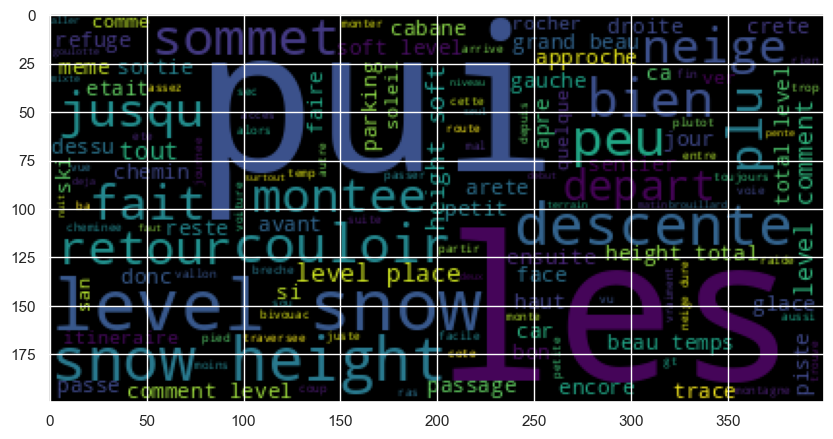

In [77]:
text = " ".join(i for i in df["full_text_normalized"])
plt.figure(figsize=(10, 10))
wc = WordCloud().generate(text)
plt.imshow(wc)

# Column descriptions

In [78]:
df

,document_id,quality,access_condition,avalanche_signs,condition_rating,date_end,date_start,elevation_access,elevation_down_snow,elevation_max,...,cooked_route_description_normalized,cooked_timing_normalized,cooked_weather_normalized,full_text_normalized,is_refuge,is_cabane,is_arete,is_glacier,is_couloir,is_goulotte
0,978489,fine,NaN,['no'],good,2018-03-10,2018-03-10,NaN,NaN,2810.0,...,https randoludo blog4ever com pic peric couloi...,depart 7h35 station ski formigueres pied coulo...,nuageux sommet vent fort venant sud,secteur sauvage grandiose route station ski c...,False,False,False,False,True,False
1,641687,medium,cleared,NaN,good,2015-06-12,2015-06-12,1135.0,NaN,2339.0,...,pont ruisseau hourc 1135 sentier file e passe ...,9h43 13h18 montee 1h55 parcours 3h35,impression beau vite occulte puis brouillard d...,epiphenomene meteorologique incongru balade ma...,False,True,False,False,False,False
2,879144,medium,NaN,['no'],good,2017-04-28,2017-04-28,NaN,1735.0,2831.0,...,,2h30 approche hourquette ancizan jusqu pied co...,grand beau matin jusqu a 12h environ assez fro...,etait journee fin avril a rater petit coup bla...,False,False,False,False,True,False
3,185409,medium,NaN,NaN,NaN,2008-04-14,2008-04-14,1970.0,NaN,2702.0,...,,,,remontant vallee ruisseau etang faury suivant ...,True,False,False,False,True,False
4,1531141,fine,NaN,['no'],good,2023-05-01,2023-05-01,1730.0,2170.0,2529.0,...,super bareges 1730 piste toue puis thalweg cou...,depart 9h25 retour 14h01 montee 1h45 2h27 3h40...,couvert puis eclaircie meteo joue chat a souris,fin saison lancee 8239 a pris executer retrait...,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6084,1603048,fine,NaN,['no'],average,2023-12-29,2023-12-29,1428.0,NaN,2712.0,...,itineraire suivi jusqu a aplomb bloc coince,6h23 14h15,couverture nuageuse degageant apres midi,partis voir curiosite apres avoir passe les 2 ...,False,False,False,False,True,False
6085,1070679,great,NaN,NaN,good,2019-01-13,2019-01-13,1000.0,NaN,1989.0,...,betpouey stationnement haut village 1000 les p...,depart 10h12 retour 13h38 montee 2h06 parcours...,temps couvert fait grise mine,cela prend tripes 8239 vas dire filons ski 823...,False,True,False,False,False,False
6086,1472715,fine,NaN,NaN,excellent,2022-10-05,2022-10-05,1800.0,NaN,1941.0,...,tournant patrons 1800 piste puis sentier rejoi...,depart 9h45 retour 12h12 montee 2h00 parcours ...,beau,les confidentiels anges cirque resteront encor...,False,False,False,False,True,False
6087,797869,medium,NaN,NaN,NaN,2016-09-02,2016-09-02,1300.0,NaN,2939.0,...,montee cau pic axe plo coume entre 60 70 appre...,dpt 8h tramezaygues 10h30 cote2664 12h sommet ...,grand bleu,amuserai a descendre pic tramezaygues sans poi...,False,False,True,False,False,False


document_id : int64
min : 58558
max : 1621060


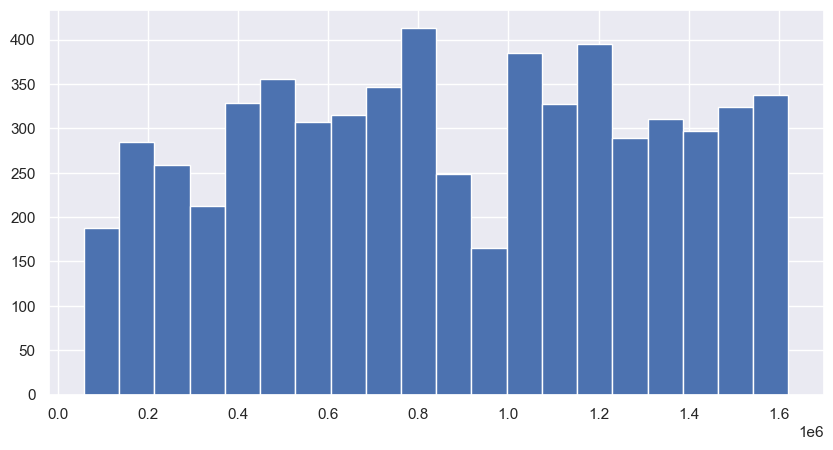

quality : object
access_condition : object
avalanche_signs : object
condition_rating : object
date_end : object
date_start : object
elevation_access : float64
min : 0.0
max : 3222.0


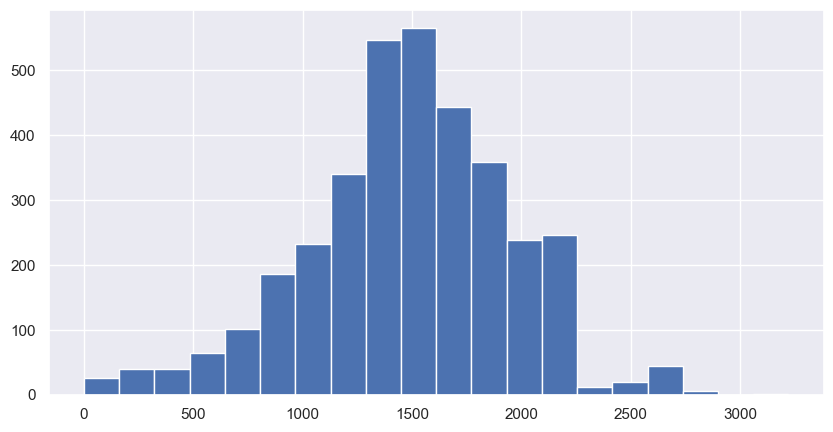

elevation_down_snow : float64
min : 0.0
max : 3400.0


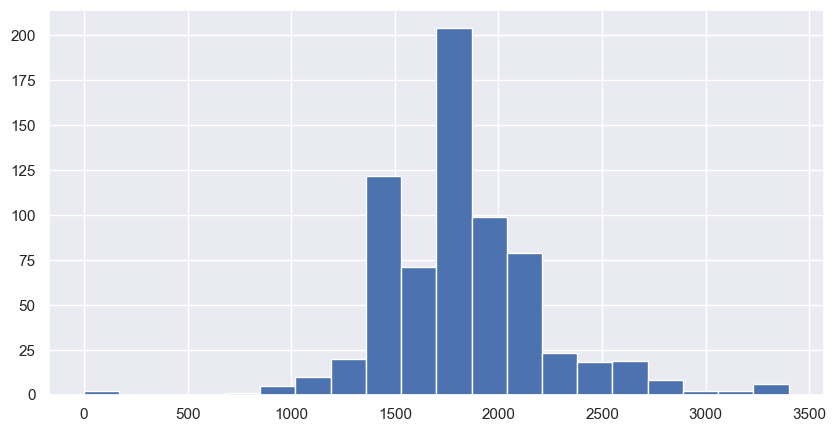

elevation_max : float64
min : 2.0
max : 3408.0


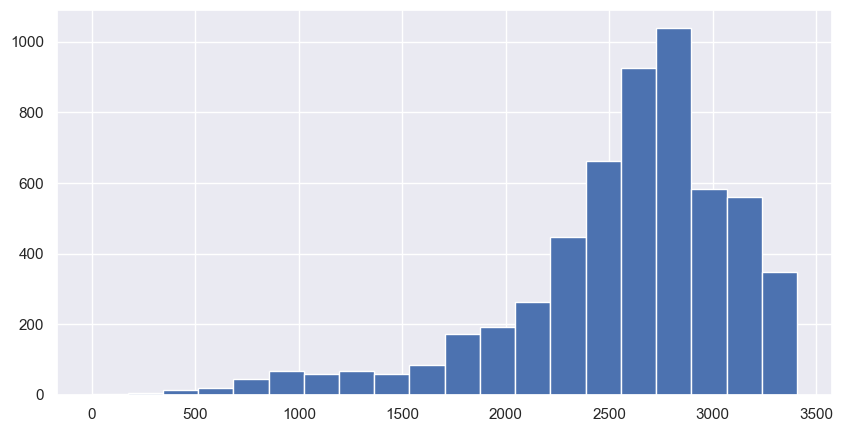

elevation_min : float64
min : 0.0
max : 3000.0


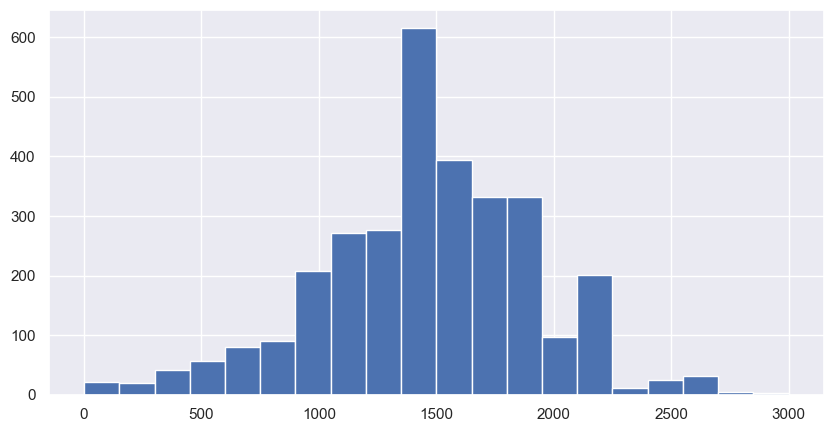

elevation_up_snow : float64
min : 0.0
max : 3200.0


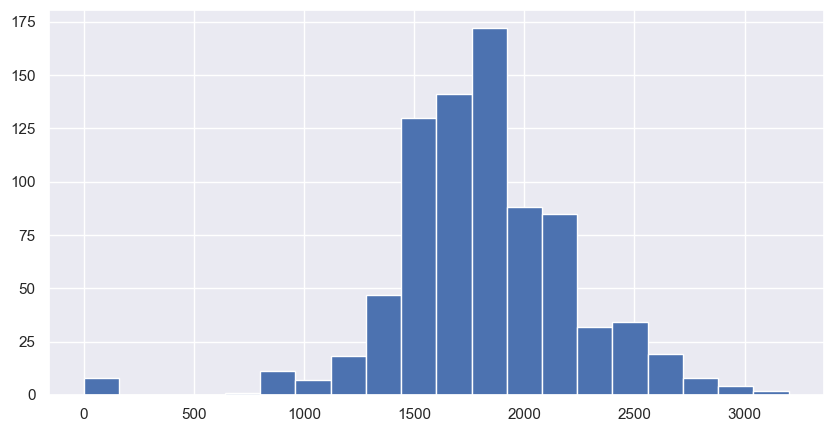

frequentation : float64
min : 0.0
max : 3.0


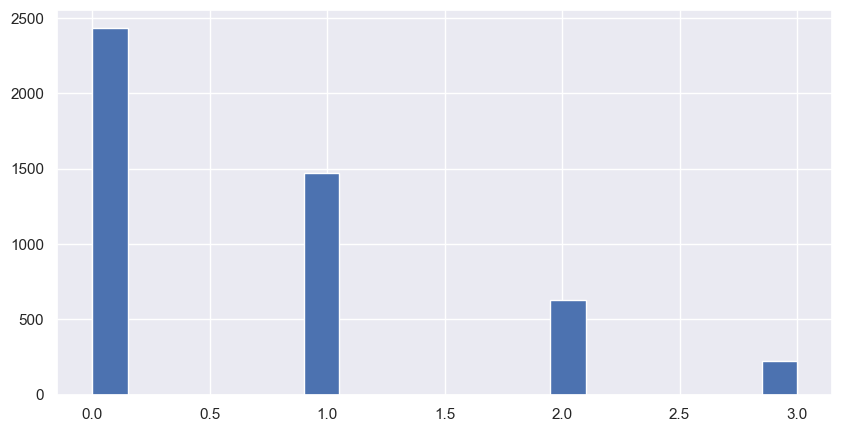

glacier_rating : float64
min : 0.0
max : 2.0


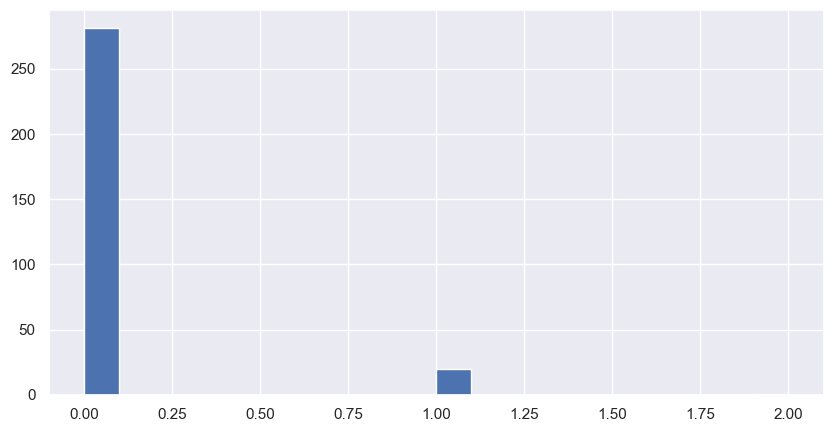

height_diff_down : float64
min : 0.0
max : 8524.0


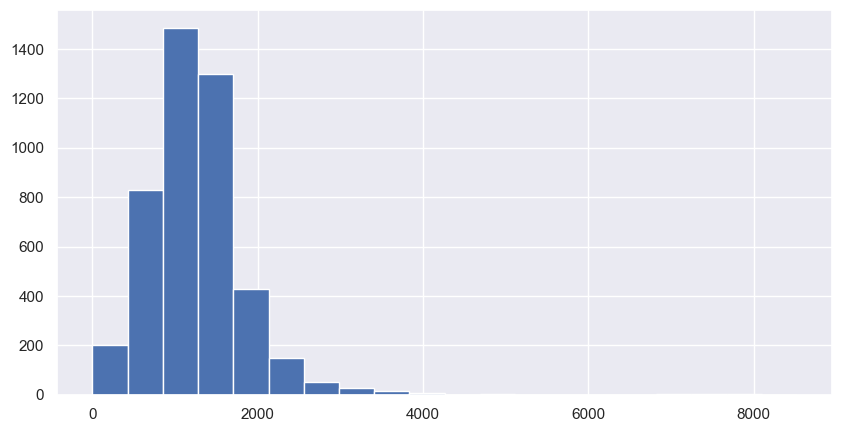

height_diff_up : float64
min : 0.0
max : 8600.0


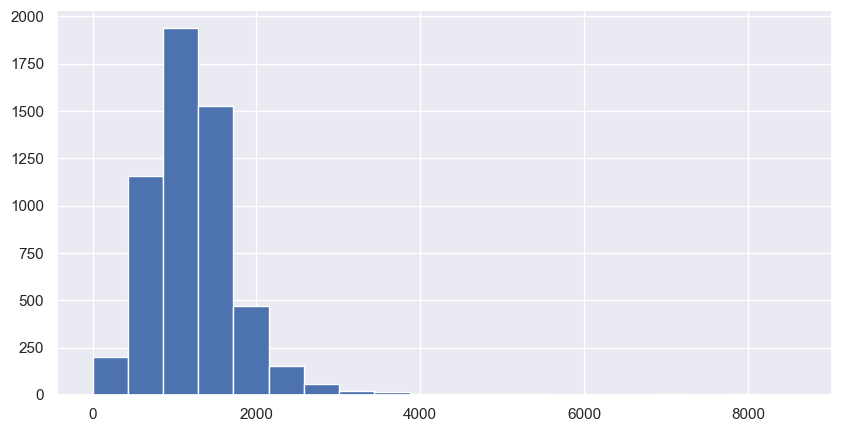

hut_status : object
length_total : float64
min : 0.0
max : 500000.0


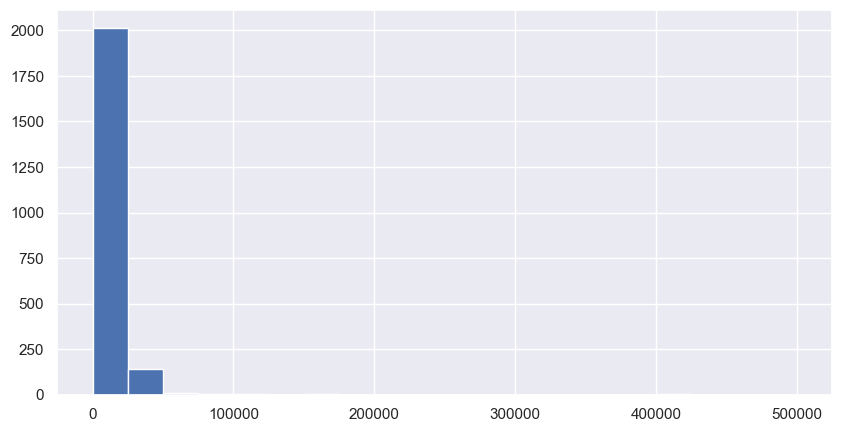

lift_status : object
partial_trip : object
participant_count : float64
min : 0.0
max : 155.0


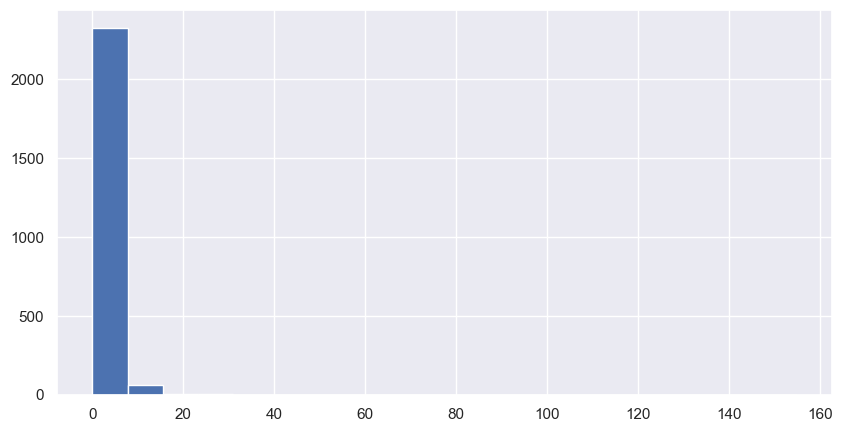

public_transport : object
hiking_rating : float64
min : 0.0
max : 4.0


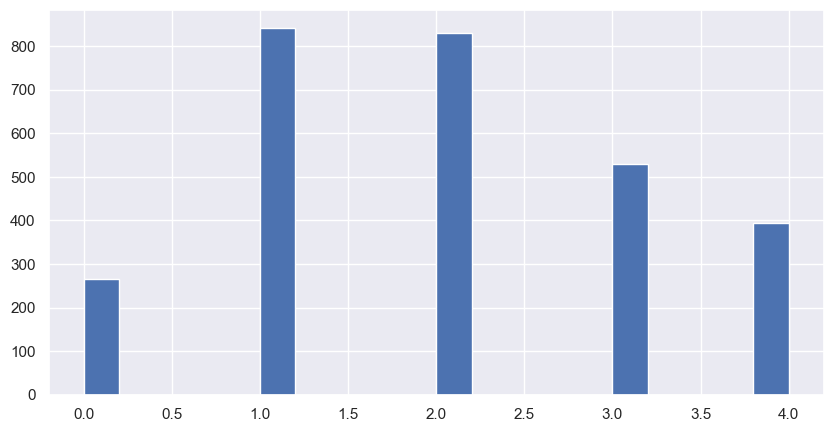

snow_quality : float64
min : 0.0
max : 4.0


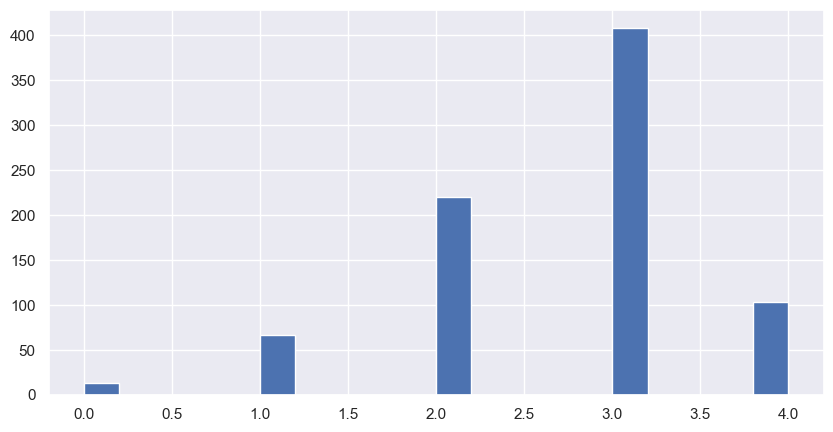

snow_quantity : float64
min : 0.0
max : 4.0


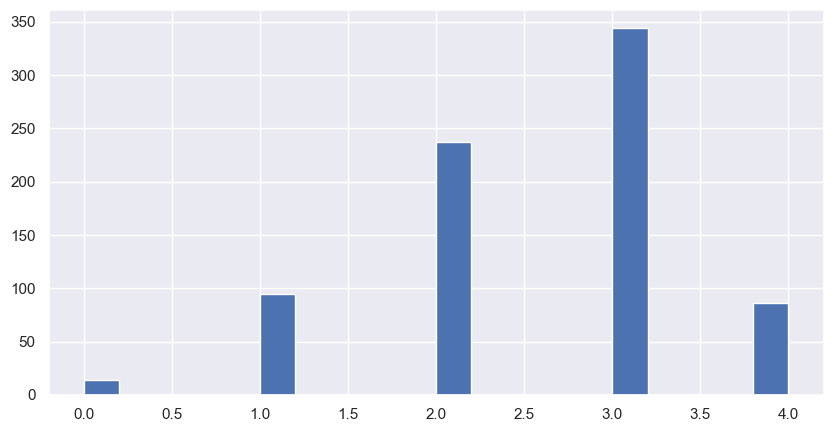

global_rating : float64
min : 0.0
max : 16.0


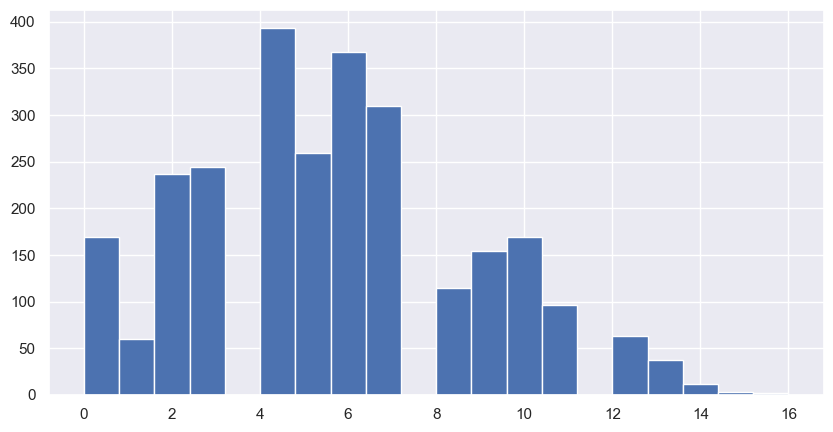

height_diff_difficulties : float64
min : 0.0
max : 3000.0


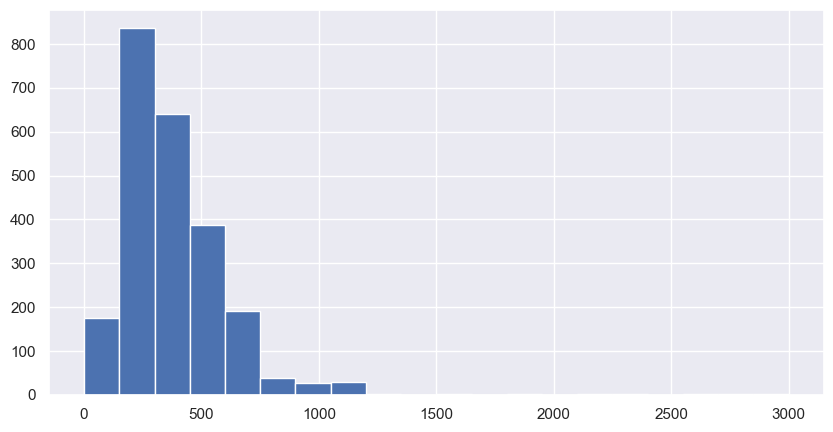

engagement_rating : float64
min : 0.0
max : 4.0


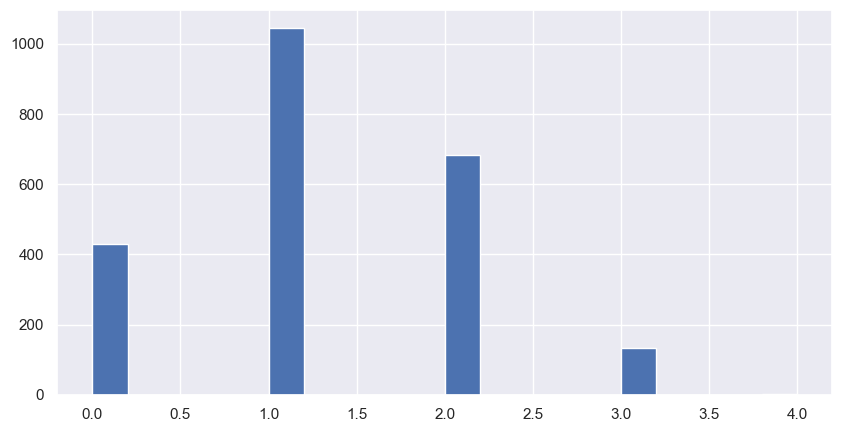

ski_rating : float64
min : 0.0
max : 14.0


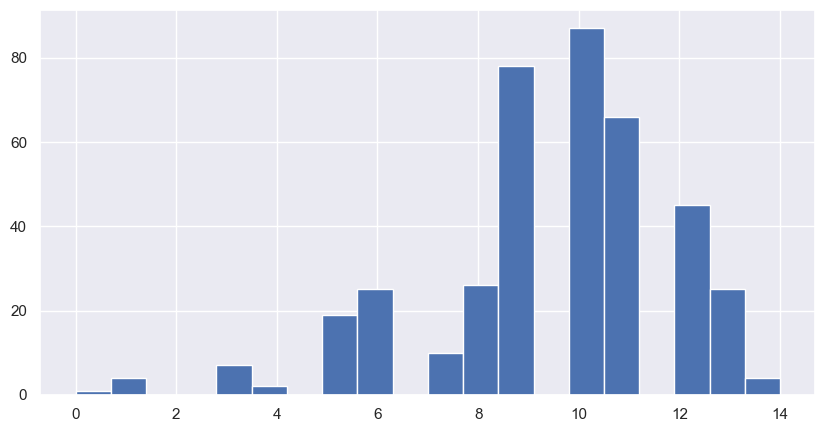

labande_global_rating : float64
min : 0.0
max : 13.0


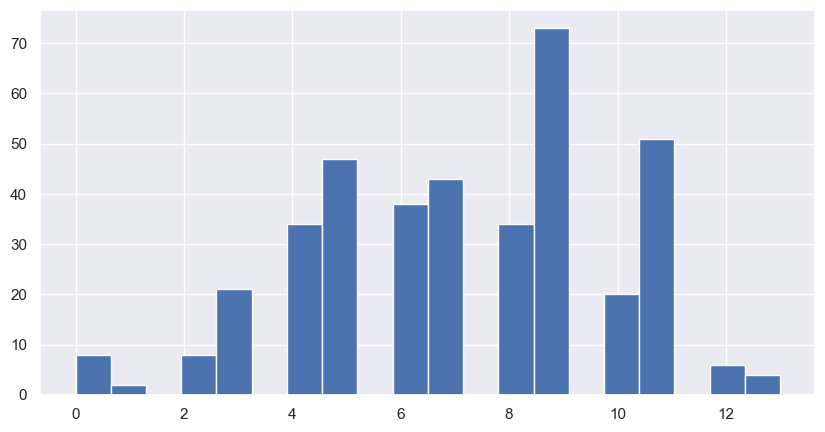

activity_snow_ice_mixed : bool


/tmp/ipykernel_6340/730863373.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].replace({True: 1, False:0}).hist(bins=20)


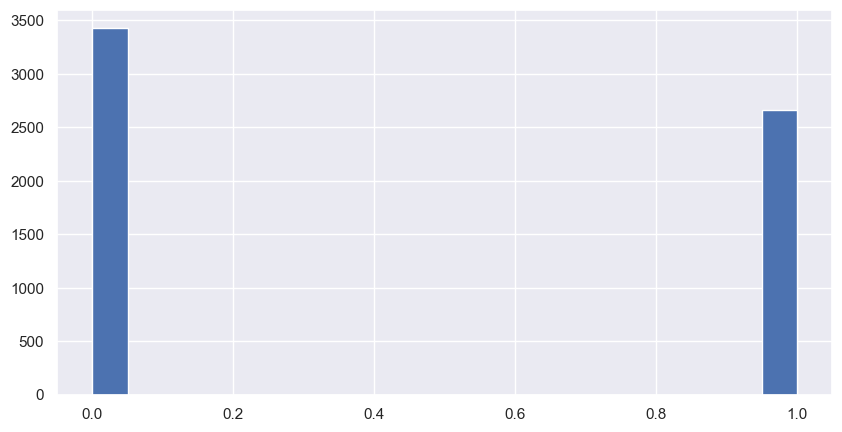

geom : object
associated_route_ids : object
associated_forum_usernames : object
country : object
admin_limits : object
range : object
cooked_lang : object
cooked_title : object
cooked_description : object
cooked_summary : float64
min : nan
max : nan


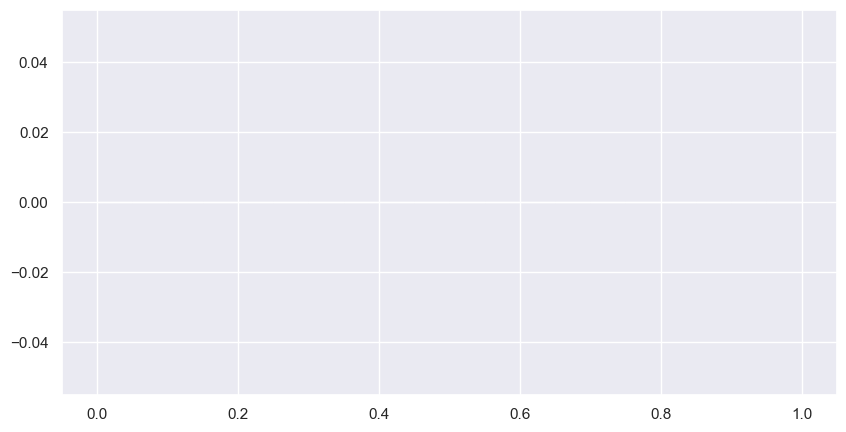

cooked_access_comment : object
cooked_avalanches : object
cooked_conditions : object
cooked_conditions_levels : object
cooked_hut_comment : object
cooked_participants : object
cooked_route_description : object
cooked_timing : object
cooked_weather : object
link : object
activity_hiking : object
activity_skitouring : object
activity_mountain_climbing : object
activity_ice_climbing : object
activity_paragliding : object
activity_snowshoeing : object
activity_rock_climbing : object
activity_mountain_biking : object
activity_via_ferrata : object
cooked_description_normalized : object
cooked_summary_normalized : object
cooked_access_comment_normalized : object
cooked_avalanches_normalized : object
cooked_conditions_normalized : object
cooked_conditions_levels_normalized : object
cooked_hut_comment_normalized : object
cooked_route_description_normalized : object
cooked_timing_normalized : object
cooked_weather_normalized : object
full_text_normalized : object
is_refuge : bool


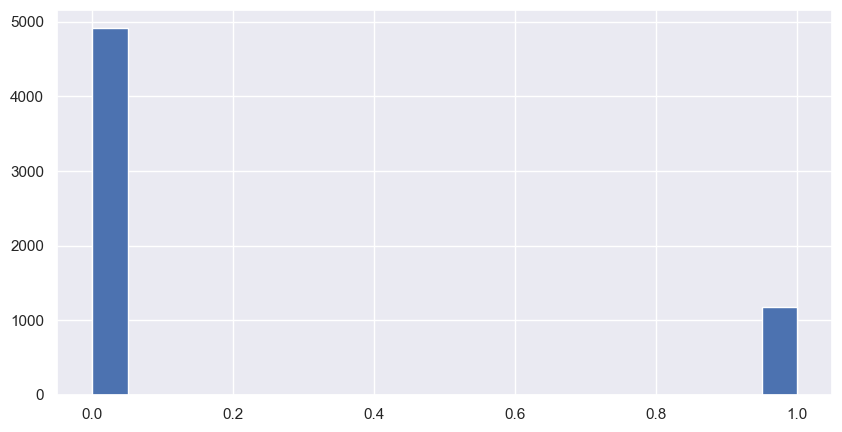

is_cabane : bool


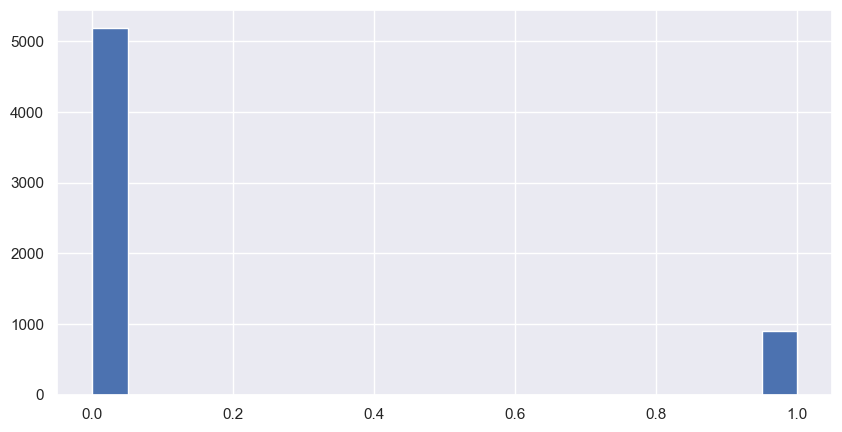

is_arete : bool


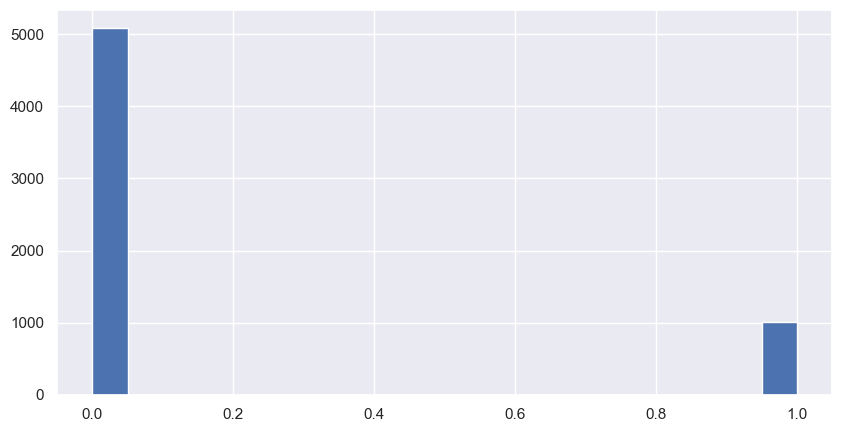

is_glacier : bool


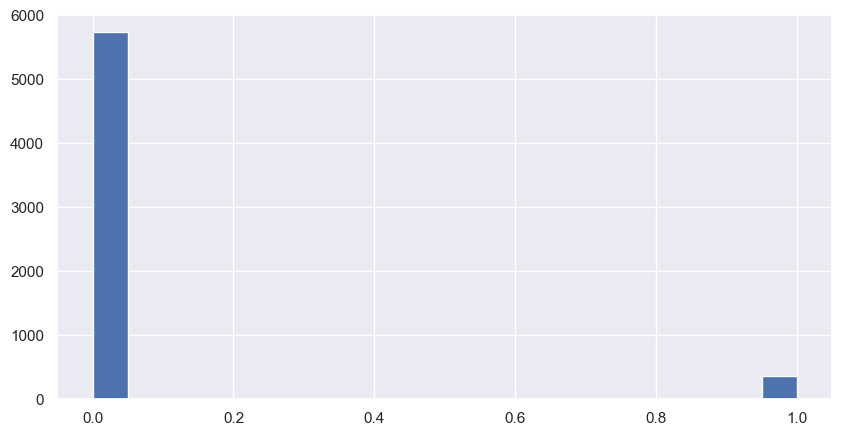

is_couloir : bool


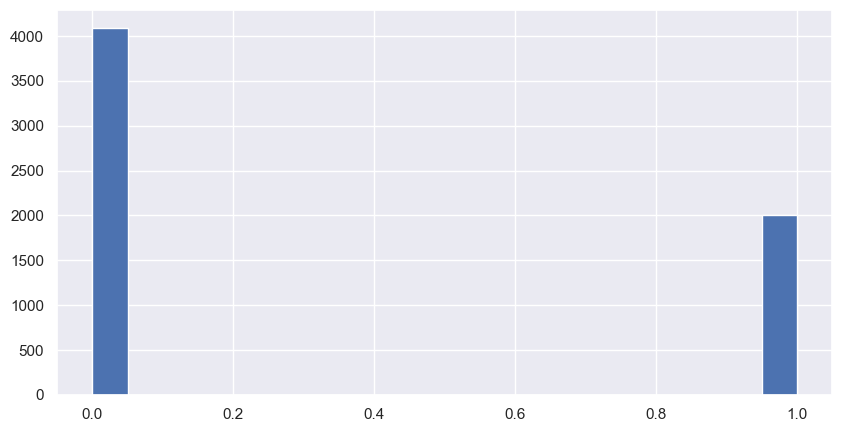

is_goulotte : bool


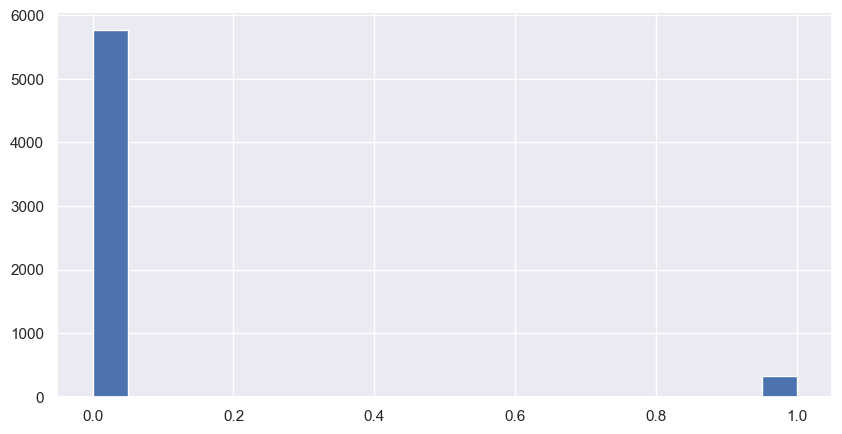

In [79]:
for col in df.columns:
    print(f"{col} : {df[col].dtype}")
    if pd.api.types.is_bool_dtype(df[col]):
        plt.figure(figsize=(10, 5))
        df[col].replace({True: 1, False:0}).hist(bins=20)
        plt.show()
    elif pd.api.types.is_numeric_dtype(df[col]):
        print(f"min : {df[col].min()}")
        print(f"max : {df[col].max()}")
        plt.figure(figsize=(10, 5))
        df[col].hist(bins=20)
        plt.show()

# Distance calculation

In [80]:
cols = [
    "activity_snow_ice_mixed",
    "elevation_access",
    "elevation_down_snow",
    "elevation_max",
    "elevation_min",
    "elevation_up_snow",
    # "frequentation",
    "glacier_rating",
    "height_diff_down",
    "height_diff_up",
    "length_total",
    # "participant_count",
    # "snow_quality",
    # "snow_quantity",
    "global_rating",
    "height_diff_difficulties",
    "engagement_rating",
    "hiking_rating",
    "ski_rating",
    "labande_global_rating",
    "is_refuge",
    "is_cabane",
    "is_arete",
    "is_glacier",
    "is_couloir",
    "is_goulotte"
]

## Fill na with med

In [81]:
for col in cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

## Global distance

In [31]:
scaler = StandardScaler()
scaler = scaler.fit(df[cols])
scaled_data = scaler.transform(df[cols])

In [32]:
scaled_data

array([[ 1.13462677,  0.00268456, -0.01508397, ..., -0.24882003,
         1.42879619, -0.23706795],
       [-0.88134709, -0.98148715, -0.01508397, ..., -0.24882003,
        -0.69988989, -0.23706795],
       [ 1.13462677,  0.00268456, -0.51089068, ..., -0.24882003,
         1.42879619, -0.23706795],
       ...,
       [-0.88134709,  0.8991858 , -0.01508397, ..., -0.24882003,
         1.42879619, -0.23706795],
       [-0.88134709, -0.51485401, -0.01508397, ..., -0.24882003,
        -0.69988989, -0.23706795],
       [-0.88134709, -0.93906595, -0.01508397, ..., -0.24882003,
        -0.69988989, -0.23706795]])

In [33]:
similary_matrix = cosine_similarity(scaled_data)

<Axes: >

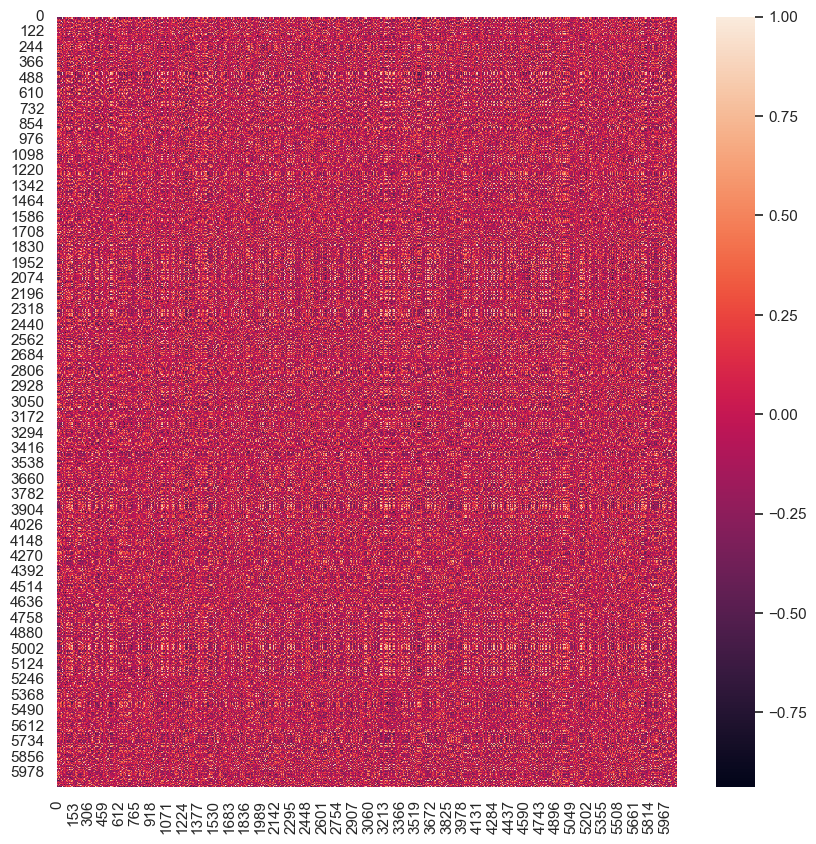

In [34]:
plt.figure(figsize=(10, 10))
sns.heatmap(similary_matrix)

### By user

In [82]:
user = "dadadu66"
selected_index = df[df["associated_forum_usernames"].str.contains(user)].index
other_index = df[~(df["associated_forum_usernames"].str.contains(user))].index

In [83]:
scaler = StandardScaler()
scaler = scaler.fit(df[cols])
scaled_data = scaler.transform(df[cols])

In [84]:
similary_matrix = cosine_similarity(scaled_data[selected_index], scaled_data[other_index])

<Axes: >

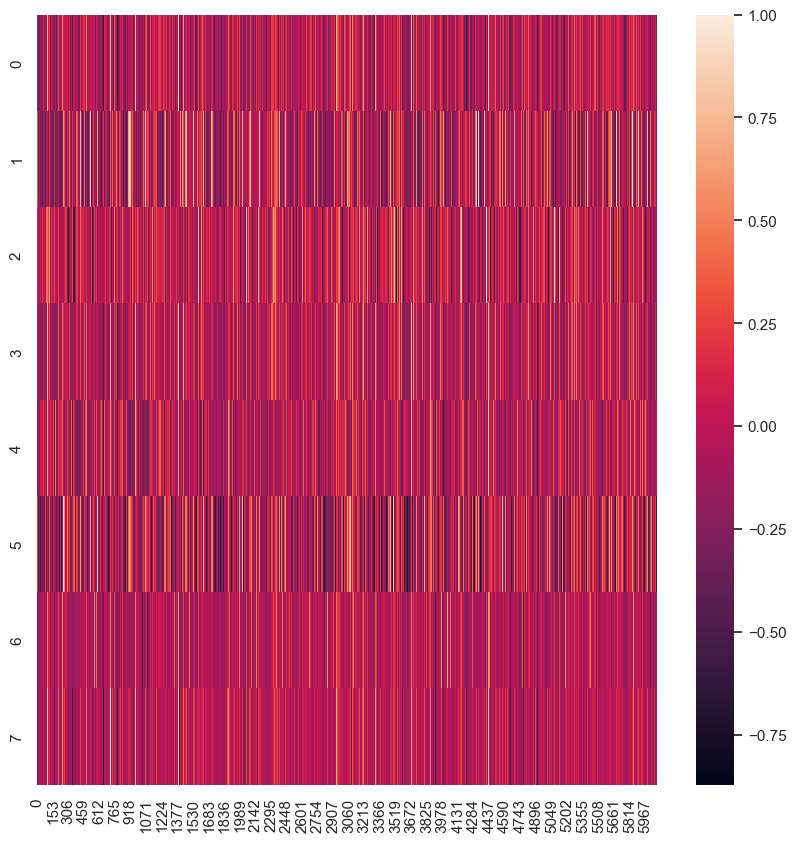

In [39]:
plt.figure(figsize=(10, 10))
sns.heatmap(similary_matrix)

In [85]:
df.loc[selected_index, "SUGGESTION"] = 1
df.loc[other_index, "SUGGESTION"] = similary_matrix.max(axis=0)

In [86]:
df.sort_values("SUGGESTION", ascending=False).loc[(df["SUGGESTION"] < 1), ["cooked_title", "link", "SUGGESTION"]].head(30)

,cooked_title,link,SUGGESTION
16,Gaube: l'art du renoncement et plan B,https://www.camptocamp.org/outings/1314633,0.994445
1265,Taillon : Voie normale depuis le col des Tente...,https://www.camptocamp.org/outings/90703,0.983340
4253,Petit Arbizon : Couloir N,https://www.camptocamp.org/outings/708370,0.980573
5077,Tour d'Eyne : Couloir NW,https://www.camptocamp.org/outings/512412,0.970808
5749,Pic de Barassé : Couloir Ker Krolic,https://www.camptocamp.org/outings/1607779,0.968661
4329,Pic de la Cabaneta de la Vall del Riu : par le...,https://www.camptocamp.org/outings/698187,0.950929
1345,Pic de Monfaucon : Depuis les granges de Camou...,https://www.camptocamp.org/outings/875062,0.948075
5165,Vignemale par Ossoue à la journée (Voie normale),https://www.camptocamp.org/outings/1237677,0.940828
3886,Presque-Pic de Sacroux : De l'Hospice de France,https://www.camptocamp.org/outings/1258198,0.938992
4410,Pique d'Endron : Crête du Sarrasi,https://www.camptocamp.org/outings/582794,0.937276


### By outing

In [87]:
outing_id = 1615742
selected_index = df[df["document_id"] == outing_id].index
other_index = df[~(df["document_id"] == outing_id)].index

In [88]:
scaler = StandardScaler()
scaler = scaler.fit(df[cols])
scaled_data = scaler.transform(df[cols])

In [89]:
similary_matrix = cosine_similarity(scaled_data[selected_index], scaled_data[other_index])

<Axes: >

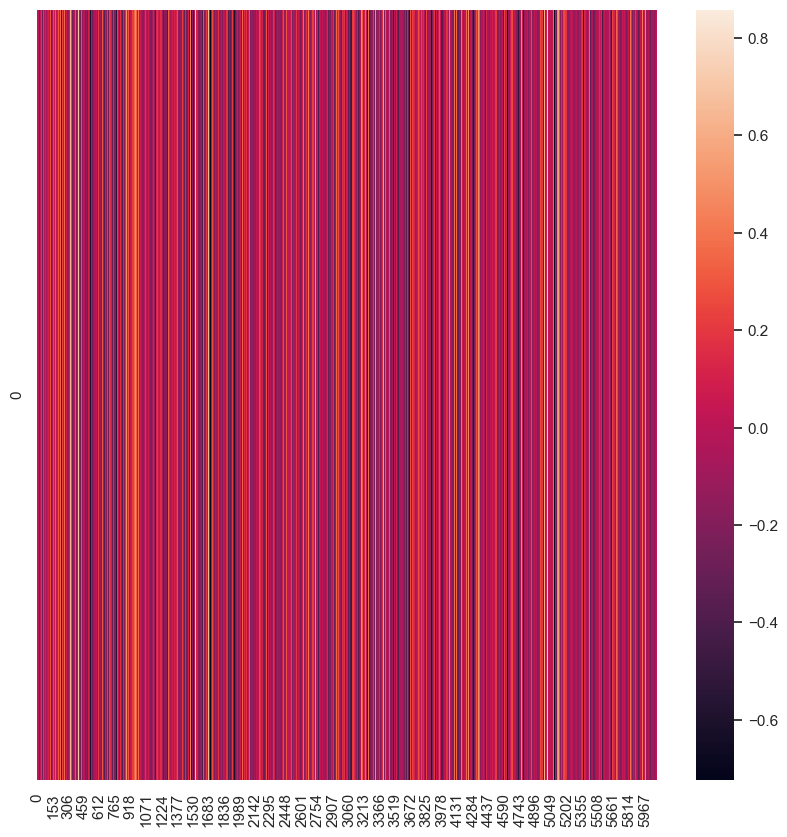

In [49]:
plt.figure(figsize=(10, 10))
sns.heatmap(similary_matrix)

In [90]:
df.loc[selected_index, "SUGGESTION"] = 1
df.loc[other_index, "SUGGESTION"] = similary_matrix.max(axis=0)

In [91]:
df.sort_values("SUGGESTION", ascending=False).loc[(df["SUGGESTION"] < 1), ["cooked_title", "link", "SUGGESTION"]].head(30)

,cooked_title,link,SUGGESTION
1964,Pico de Boum: Par le refuge du Maupas,https://www.camptocamp.org/outings/777450,0.858543
517,Tour du cirque de Baiau : coma Pedrosa & Medec...,https://www.camptocamp.org/outings/1483564,0.822000
80,Mont Perdu : Depuis le Port de Bujaruelo/Boucharo,https://www.camptocamp.org/outings/785052,0.817265
1488,Aneto : Couloir Estasen,https://www.camptocamp.org/outings/629703,0.811364
3216,Maladeta : Voie Normale,https://www.camptocamp.org/outings/764212,0.777507
5011,Aneto : Couloir Estasen,https://www.camptocamp.org/outings/522094,0.772743
904,Mont Perdu : Depuis le Port de Bujaruelo/Boucharo,https://www.camptocamp.org/outings/801807,0.771660
5495,Pic des Spijeoles : Grand dièdre,https://www.camptocamp.org/outings/894913,0.760711
4779,Pic du Milieu : Versant N - voie normale,https://www.camptocamp.org/outings/1012465,0.754613
4772,Pique d'Estats Verdaguer et Montcalm,https://www.camptocamp.org/outings/1595662,0.753094
